<a href="https://colab.research.google.com/github/mkpvasu/Machine-Learning-Problems/blob/main/HW3_Sentiment_Analysis_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting sentiment from product reviews

### The coding portion will be submitted on EdStem and the concept portion on Gradescope.

The goal of this first notebook is to explore logistic regression and feature engineering with sklearn.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Use Pandas Dataframes to do feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given a classifier, create a confusion matrix
* Compare multiple logistic regression models.

Copyright ©2021 Emily Fox, Hunter Schafer, Valentina Staneva.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Autumn Quarter 2021 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.


In [4]:
import math
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer

sns.set()
%matplotlib inline


# Data preparation

We will use a dataset consisting of food product reviews on Amazon.com [source](http://jmcauley.ucsd.edu/data/amazon/).

In [5]:
from google.colab import files
uploaded = files.upload()

products = pd.read_csv('food_products.csv')

products

Saving food_products.csv to food_products.csv


,product_id,summary,review,rating
0,4408,Does increase milk supply,This really helped to increase my milk supply....,3.0
1,4209,One bad packet ruins the product!,I should have stayed with Idahoan brand. Poor ...,1.0
2,8623,CAULIFLOWER PASTA!?,"As the pasta cooked, I read the box to see wha...",4.0
3,9439,Tasty and inexpensive,I really like this cereal. The flavor is sligh...,5.0
4,7110,I'm Confused,The label on the bowl says 35 grams is in the ...,2.0
...,...,...,...,...
1245,2870,10 times the price,I recently bought Domino 10 lb premium cane su...,1.0
1246,8823,Sweet & Crunchy Peanuts,While these are not the highest quality peanut...,3.0
1247,6343,Annies GF Mac Deluxe,"I had been using Annies GF Mac n Cheese, then ...",4.0
1248,5801,"OK, but Check the Pricing",Dr. Oz recommended this brand of coconut water...,3.0


## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [6]:
products = products[products['rating'] != 3]
products = products.copy()  # This is to avoid having a view on the old data

len(products)

889

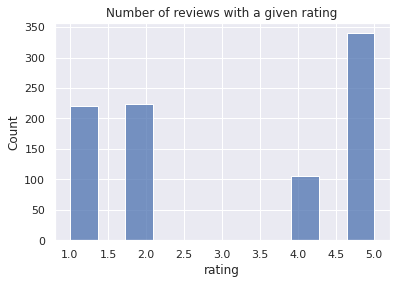

In [7]:
plt.title('Number of reviews with a given rating')
sns.histplot(products['rating'])

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [8]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products.head()

,product_id,summary,review,rating,sentiment
1,4209,One bad packet ruins the product!,I should have stayed with Idahoan brand. Poor ...,1.0,-1
2,8623,CAULIFLOWER PASTA!?,"As the pasta cooked, I read the box to see wha...",4.0,1
3,9439,Tasty and inexpensive,I really like this cereal. The flavor is sligh...,5.0,1
4,7110,I'm Confused,The label on the bowl says 35 grams is in the ...,2.0,-1
5,1373,Flat,Doesn't taste like ginger. Thought it would s...,2.0,-1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Build the word count vector for each review

Let us explore a specific example of a food product. We have information about the product, the review left, and both the rating that was given and the sentiment label we computed.

In [9]:
products.iloc[21]

product_id                                                  918
summary                                It's PRIME-arily Lobster
review        if it's primarily made from lobster, what else...
rating                                                        4
sentiment                                                     1
Name: 34, dtype: object

To work with the text data, we will need to eventually turn it into word counts. In other words, we will be making a feature for every word that could possibly appear in the data, and the value for that feature for one example would be the number of times that word appears in that example. 

To accomplish this, we will need to do two data transformation:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.



> **Aside**. In this assignment, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. 
> 
> If you are curious in learning how to handle these complexities in practice, you might be interested in  researching more about tokenization and NLP like [this page](https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4) shows. Note that you do not need to do any of that stuff for this assignment.

So first, we remove punctuation with the code in the next cell.

In [10]:
def remove_punctuation(text):
    if type(text) is str:
        return text.translate(str.maketrans('', '', string.punctuation))
    else:
        return ''
    
products['review_clean'] = products['review'].apply(remove_punctuation)
products['review_clean']

1       I should have stayed with Idahoan brand Poor B...
2       As the pasta cooked I read the box to see what...
3       I really like this cereal The flavor is slight...
4       The label on the bowl says 35 grams is in the ...
5       Doesnt taste like ginger  Thought it would sav...
                              ...                        
1243    This is the product that rocked my world In a ...
1244    I am so glad Amazon has this set up for subscr...
1245    I recently bought Domino 10 lb premium cane su...
1247    I had been using Annies GF Mac n Cheese then I...
1249    I TAKE CHANCES WITH THINGS I SHOULDNT  END RES...
Name: review_clean, Length: 889, dtype: object

Next, we use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to get counts for each word. 

In [11]:
# Make counts
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(products['review_clean'])

# Make a new DataFrame with the counts information
product_data = pd.DataFrame(count_matrix.toarray(),
        index=products.index,
        columns=vectorizer.get_feature_names())

# Add the old columns to our new DataFrame. 
# We won't use review_clean and the summary in our model, but we will keep
# them to look at later.
product_data['sentiment'] = products['sentiment']
product_data['review_clean'] = products['review_clean']  
product_data['summary'] = products['summary']

product_data

,0000,002,004,004oz,012months,032,051,08,0f,10,100,1000,100gr,100mg,10112013seller,1012,1024,107,10x,11,110,1133,114,117i,11g,11ounce,12,120,1200,1258201cm,125mgmy,128,1292014list,12absolutely,12andcoco,12g,12i,12ounce,12pack,12yr,...,youre,youreal,yours,yourself,youso,youtheyre,youtube,youve,youwhen,youzico,yucateco,yuck,yuckalso,yuckgot,yuckthe,yucky,yuk,yum,yumbbq,yumits,yummier,yummy,yummyflavorfull,yumyum,yup,zabars,zanthan,zero,zhenas,zico,zico1,zico3,zicos,zillion,zinger,zip,ziplock,sentiment,review_clean,summary
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,I should have stayed with Idahoan brand Poor B...,One bad packet ruins the product!
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,As the pasta cooked I read the box to see what...,CAULIFLOWER PASTA!?
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,I really like this cereal The flavor is slight...,Tasty and inexpensive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,The label on the bowl says 35 grams is in the ...,I'm Confused
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,Doesnt taste like ginger Thought it would sav...,Flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,This is the product that rocked my world In a ...,Fake.
1244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,I am so glad Amazon has this set up for subscr...,Addictive!
1245,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,I recently bought Domino 10 lb premium cane su...,10 times the price
1247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,I had been using Annies GF Mac n Cheese then I...,Annies GF Mac Deluxe


We have now created a lot of features to work with! Note that in the table above, we will have one feature for each word taht appeared in the data and the value for that feature is the count of that word in that review. So for example, if review 5 had the word "dog" in it 3 times, the value in row 5 and column "dog" would be 3.

## Split data into training, validation and test sets.

Let's perform a train/validation/test split with 80% of the data in the training set, 10% of the data in the validation set, 10% test. Note that we use `random_state=3` so that everyone gets the same result.

In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(product_data, test_size=0.2, random_state=3)
validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=3)

# Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points.

To "train" the majority class classifier, you should simply find the most frequent target in the training data.

### **Question 1:** Majority class classifier
* Compute the most frequent label and store it in a variable called `majority_label`.
* What is the validation accuracy of the majority class classifer. Store your result as a number between 0 and 1 in a variable called `majority_classifier_validation_accuracy`.
  
  *Hint:* pandas allows you to take the sum of a boolean series - true values are equal to 1, false values are equal 0.

In [13]:
### edTest(test_q1_majority_classifier) ###

# TODO "Train" a majority class classifier and calculate its validation accuracy

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

features = vectorizer.get_feature_names()
majority_clf = DummyClassifier(strategy='most_frequent').fit(train_data[features], train_data['sentiment'])
majority_label = majority_clf.predict(validation_data[features])
print(majority_label[0])

majority_classifier_validation_accuracy = accuracy_score(validation_data['sentiment'],majority_label)
print(majority_classifier_validation_accuracy)

-1
0.5168539325842697


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the columns representing word coutnts as features and the column **sentiment** as the target. We will set **no regularization penalty** (and set `random_state=1` to get the same answer as everyone else). 

You can see scikit-learn's documentation for LogisticRegression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Note that the parameter for this class to control regularization is named `C` and it represents the inverse of the penalty strenght. In other words $C = \frac{1}{\lambda}$. This means to have very little regularization, we make `C` a very large number (corresponding to a very small $\lambda$).

In [14]:
features = vectorizer.get_feature_names()

# Note: C = 1/Lambda. Setting C to a really high value is the same as setting lambda = 0
sentiment_model = LogisticRegression(penalty='none', random_state=1)
sentiment_model.fit(train_data[features], train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's look at some of the coefficients and the corresponding words. The weights are stored in a `coef_` property: 

In [15]:
coefficients = sentiment_model.coef_[0]
print('Smallest coefficient', coefficients.min())
print('Largest coefficient:', coefficients.max())

Smallest coefficient -11.175390439425424
Largest coefficient: 19.97931494988929


### **Question 2:** Most Positive/Negative Word
For the sentiment model we trained above, compute the word with the most negative weight and the word with the most positive weight.

Store your results in the variables `most_negative_word` and `most_positive_word`.

While you only need to write code to compute the most negative and most positive, we also recommend printing out the words with the highest magnitude coefficients to make sure they make sense.


In [16]:
### edTest(test_q2_most_pos_neg_words) ###

# TODO Find the most positive word and most negative word in the sentiment_model

most_negative_word = None
most_positive_word = None

for i in range(len(coefficients)):
  if(coefficients[i] == coefficients.min()):
    most_negative_word = features[i]

print(most_negative_word)

for i in range(len(coefficients)):
  if(coefficients[i] == coefficients.max()):
    most_positive_word = features[i]

print(most_positive_word)

not
great


## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **validation data**. In this first section, we will restrict the examples we are looking at to 3 examples in the validation dataset. We refer to this set of 3 examples as the **sample_data**.

In [17]:
sample_data = validation_data
sample_data[['sentiment', 'review_clean', 'summary']]

,sentiment,review_clean,summary
169,1,Great product keeps well enough that I can or...,The Kids Love it!
70,-1,This coconut water has a very weird smell and ...,Weird Odor with a Bad After Taste!
1154,-1,REally wanted to like this but it has no taste...,"Fat free and taste free, sorry to say!"
290,-1,I know what Ginger tastes like and this is NOT...,NO GOOD!!!!
1021,1,Read the reviews here with a grain of salt A ...,Great product
...,...,...,...
640,1,We love this cereal both parents child and tod...,Organic Mesa Sunrise is awesome!
834,1,If you are still committed to being healthy wh...,The Original
866,-1,ANNIE CHUNG PRODUCTS ARE HORRID GROSSLY STICK...,NOT WORTH ONE STAR - GIVE IT A ZERO
71,-1,I dont have to lose weight However I am fighti...,Maltitol is not what I need


### Predicting sentiment
Let's start by predicting the sentiment of the 3 examples in the `sample_data`. The `predict_proba` method on the `LogisticRegression` class outputs a probability for each class possible.

The output has one row for each example. Each row is an array of 2 numbers, the first is the predictor's prediction for the probability it is a negative sentiment example, and the second is the probability of it being a positive sentiment example.

In [18]:
print('  Prob Negative, Prob Positive')
print(sentiment_model.predict_proba(sample_data[features]))

  Prob Negative, Prob Positive
[[4.88498131e-15 1.00000000e+00]
 [1.00000000e+00 2.45015249e-29]
 [9.99996439e-01 3.56051803e-06]
 [1.00000000e+00 1.26154372e-25]
 [1.00000000e+00 1.02325122e-23]
 [1.00000000e+00 7.84843467e-23]
 [1.00000000e+00 6.80914475e-21]
 [1.00000000e+00 5.56833915e-22]
 [1.00000000e+00 1.11693736e-31]
 [2.33590924e-13 1.00000000e+00]
 [1.00000000e+00 3.08339283e-22]
 [1.13051390e-01 8.86948610e-01]
 [9.93223495e-01 6.77650541e-03]
 [4.26513802e-09 9.99999996e-01]
 [0.00000000e+00 1.00000000e+00]
 [9.99967826e-01 3.21738523e-05]
 [9.93962129e-01 6.03787141e-03]
 [1.04360964e-12 1.00000000e+00]
 [9.99999278e-01 7.21832229e-07]
 [1.00000000e+00 2.61938118e-36]
 [4.87165863e-13 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 5.32945598e-35]
 [2.48863783e-05 9.99975114e-01]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.81935693e-13]
 [0.00000000e+00 1.00000000e+00]
 [1.02820863

We are also able to make predictions using the `predict` function

In [19]:
print('Predicted labels')
print(sentiment_model.predict(sample_data[features]))

Predicted labels
[ 1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1 -1  1  1 -1  1
  1  1  1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1  1
  1  1 -1  1 -1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1 -1 -1 -1]


### **Question 3:** Find the most positive (and negative) review

We now turn to examining the full **validation_data** dataset <span style="color:red">(not sample_data)</span>, , and use `sklearn` to form predictions on all of the data points for faster performance.

Using the `sentiment_model`, find review in the **validation_data** with the **highest probability** of being classified as a **positive review**. Also, find the reivew with the **highest probability** of being classified as a **negative review**. We refer to these as the "most positive review" and "most negative review" respectively. Store the `review_clean` column value for each of these rows in `most_positive_review` and `most_negative_review` respectively.

If there is a tie for the most positive/negative reivew, you should always grab the one that appears *first* in the validation data.

*Hint*: Once you know the index of the most positive/negative reviews, use the `.iloc[]` accessor on the DataFrame to get that row and find its `review_clean` value.

In [38]:
### edTest(test_q3_most_positive_negative_review) ###

# TODO Find the review_clean values for the most positive and most negative review

validation_data[['sentiment','review_clean','summary']]
valprob = sentiment_model.predict_proba(validation_data[features])
posmax = np.argmax(valprob[:,1])
most_positive_review = validation_data.iloc[posmax]['review_clean']
print(most_positive_review)
negmin = np.argmax(valprob[:,0])
most_negative_review = validation_data.iloc[negmin]['review_clean']
print(most_negative_review)

I have been on an organic foods diet for almost a year now and I have become much more sensitive to what I eat and drink Out are the energy drinks loaded with sugars caffeine and artificial ingredients In are the more gentler and natural energy boosters This was  a surprise for me I really liked it and it did give an energy boost without any late energy crashesThe flavor is nice A good palatable taste and feel in the mouth No bad after taste It sits well on the stomach even an empty one It provides and fairly quick ramp up in energy and alertness and lasts for several hours to all day The ramp down in gently and hardly noticeable I like the ingredients and the overall effectI am finding that I need less energy boosting as my diet is becoming cleaner and healthier However I am going to rely on these until the day when I can maintain great energy levels without supports Or at least keeps a few in the fridge for special occasions 5 Stars easy Hope you get as much out of it as I have
This 

Do you notice something special about those reviews? They are both pretty long! Here we just count number of words regardless of the length of the review but clearly that can affect the results, and in practice one can use some techniques to normalize the counts to avoid prioritizing long reviews over shorter ones (we will discuss this idea in a future week).

### **Question 4:** Compute validation accuracy
Compute the validation accuracy for the model we just trained. Report the validationaccuracy as a number between 0 and 1 stored in a variable called `sentiment_model_validation_accuracy`.

Below, calculate the accuracy of the predictor using sklearn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function.

In [19]:
### edTest(test_q4_sentiment_model_accuracy) ###

# TODO Find the validation accuracy of the sentiment model

from sklearn.metrics import accuracy_score
spred = sentiment_model.predict(validation_data[features])

sentiment_model_validation_accuracy = accuracy_score(validation_data['sentiment'],spred)
print(sentiment_model_validation_accuracy)

0.6404494382022472


### **Question 5**: Which model?
Compare the validation accuracy for this problem with the validation accuracy of the baseline majority class classifier. Which model would you predict will peform better in the future? 

* If you think the majority class classifier would do better, write `q5 = 'majority_class_classifier'`.
* If you think the sentiment model would do better, write `q5 = 'sentiment_model'`.
* If you think we can't choose which model will be best yet since we haven't assessed on the test set, write `q5 = 'cannot say'`.

Save your variable indiciating your answer in the next cell.

In [20]:
### edTest(test_q5_which_model) ###

# TODO Answer the question posed above.
q5 = 'sentiment_model'

# Create a confusion matrix

A common tool used when analyzing the peformance of a predictor in a classification problem is to look at the confusion matrix, as well as the overall accuracy.

We've created a function that will plot a confusion matrix for you given a set of inputs which are the values that should appear within each cell.
Recall that there are four values associated with a confusion matrix: true positive, true negative, false positive, and false negative which we will abberviate as TP, TN, FP, and FN, respecitvely. In other words, for the next problem we have handled the plotting code for you that you can use, but you will need to compute the values for each of the confusion matrix dimensions.

In [21]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg']) 

### **Question 6:** Compute confusion matrix values and plot

Write code below that uses the `plot_confusion_matrix` function to show the number of true positive, true negative, false positive, and false negative predictions made by your classifier. You should store the counts for each of these values in the variables:
* `tp`
* `fp`
* `fn`
* `tn` 

You might find it useful to use named parameters here (i.e. you can call `plot_confusion_matrix(tp=X, fp=Y, fn=A, tn=B)` instead of having to get the order of the parameters correct)

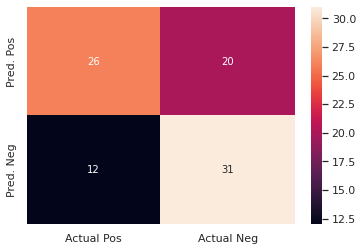

In [22]:
### edTest(test_q6_confusion_matrix) ###

# TODO Compute the four values tp, fp, fn, tn and plot them using plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_data['sentiment'], spred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

plot_confusion_matrix(tp,fp,fn,tn)

## **Question 7 and 8:** Logistic Regression with L2 regularization

One of the challenges of creating features from each word is that there are many more features than observations. It is easy to overfit. We will explore the effect of the regularization in this problem.

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. 

Like in the last assignment, we will train models with various levels of regularization starting with a small amount and then moving to a  large amount. The code here will have some similarities to the code you did in the last assignment, so you will find that to be a useful reference, but this problem will be slightly more complex since we ask you to compute a few values.

This code will be counted as two separate questions since you will be computing slightly different values, but we will ask you to compute both of them in the same starter code to reduce code duplication (since the tasks are very similar). 

We first outline what you should compute for each question and then show some general implementation notes for both problems below. Your task for this problem is to fill out the code inside the loop to compute the values described below.

We recommend focusing on the value you need to compute for Q7 and then once you have that working work on the code you need to compute Q8.

### **Question 7:** Coefficient Paths
For this question we will ask you to compute the coefficent path for each of the features in the model for various values of the regularization constant.

For each regularization strength, train a model using that regularization constant and compute table storing the coefficients of each learned predictor. Store the results in a `DataFrame` named `coef_table`.

You should end up with an `DataFrame` with column names as `'coefficients \[L2=1e-02\]', ... 'coefficients \[L2=1e+05\]'`, and a row for each word in `features`. 

Before the loop, we set up `coef_table` to have the right rows and columns, but your code will need to fill out the rest.

### **Question 8:** Train and Validation Accuracies
Similar to Q7, we want you to compute the training and validation accuracy for each learned predictor and store that in a `DataFrame` called `accuracies_table`. 

You should end up with a `DataFrame` with column names `'l2_penalty', 'train_accuracy', 'validation_accuracy'` and a row for each L2 penalty tried. The L2 penaly should be the number (not the column name from Q7) and the accuracy values should be numbers between 0 and 1 for the appropriate accuracy.

For this problem, we recommend the approach used in HW2 to build up a list of dictionaries, and then convert that to a `DataFrame` with the values described.

### Implementation Details

Some important notes about your implementation:
* When constructing a `LogisticRegression` object, make sure to use `random_state=1` to get the same results as us. We also want to avoid having an intercept term in this example, so also pass `fit_intercept=False` when constructing the `LogisticRegression` model.
* <span style="color:red">When constructing the LogisticRegression(...) model, the parameter `C` is the **inverse** of the L2 penalty (1 / L2_penalty). </span>
* Q7: To store the results of your predictor's coefficients, you will need to get the values from the `.coef_` property. Since the code for this is a little complex, we give you this line below (assumes your trained model is stored in a variable called `model`):
  ```
  coef_table[column_name] = model.coef_[0]
  ```

  Confusingly this grabs all the coefficients and treats them like a list of numbers rather than the 2D array of rows/columns that scikit-learn originally provides.

* It is okay if your code prints `ConvergenceWarnings`. This is something you would want to avoid in practice but is okay in our assignment for simplicity.

* We recommend just focusing on Q7 at first and getting the code to set up the coefficients table right. Then once that's working, evaluate the models for Q8.


In [94]:
### edTest(test_q7_q8_train_models) ###

# TODO Fill in the loop below

# Set up the regularization penalities to try
l2_penalties = [0.01, 1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = [f'coefficients [L2={l2_penalty:.0e}]' 
                    for l2_penalty in l2_penalties]

# Q7: Add the coefficients to this coef_table for each model
coef_table = pd.DataFrame(columns=['word'] + l2_penalty_names)
coef_table['word'] = features

# Q8: Set up an empty list to store the accuracies (will convert to DataFrame after loop)
accuracy_data = []

for l2_penalty, l2_penalty_column_name in zip(l2_penalties, l2_penalty_names):
    # TODO(Q7 and Q8): Train the model 
  logsreg = LogisticRegression(penalty='l2',C=(1/l2_penalty),random_state=0).fit(train_data[features],train_data['sentiment'])
    # TODO(Q7): Save the coefficients in coef_table
  coef_table[f'coefficients [L2={l2_penalty:.0e}]'] = logsreg.coef_[0]
    # TODO(Q8): Calculate and save the train and validation accuracies
  train_accuracy = logsreg.score(train_data[features], train_data['sentiment'])
  validation_accuracy = logsreg.score(validation_data[features], validation_data['sentiment'])
  accuracy_data.append([l2_penalty,train_accuracy,validation_accuracy])
acc_table = pd.DataFrame(accuracy_data)
accuracies_table = acc_table.rename(columns={0: "l2_penalty", 1: "train_accuracy", 2: "validation_accuracy"})

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [79]:
# Look at coef_table
coef_table

,word,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
0,0000,0.076811,0.026139,0.014668,0.009402,0.002636,0.000441,5.004220e-06
1,002,-0.000177,-0.000934,-0.001322,-0.001298,-0.000419,-0.000027,-4.079967e-06
2,004,-0.000177,-0.000934,-0.001322,-0.001298,-0.000419,-0.000027,-4.079967e-06
3,004oz,-0.000177,-0.000934,-0.001322,-0.001298,-0.000419,-0.000027,-4.079967e-06
4,012months,0.000466,0.001425,0.001527,0.001425,0.001076,0.000383,5.009339e-06
...,...,...,...,...,...,...,...,...
7620,zicos,-0.146430,-0.053188,-0.029682,-0.018105,-0.003775,-0.000464,-4.968101e-06
7621,zillion,-0.082585,-0.053691,-0.038140,-0.025534,-0.004617,-0.000519,-5.021791e-06
7622,zinger,-0.000275,-0.002245,-0.003756,-0.004038,-0.002400,-0.000410,-4.936411e-06
7623,zip,0.118160,0.053272,0.033318,0.021897,0.005636,0.000977,1.011543e-05


In [95]:
# Look at accuracies_table
accuracies_table

,l2_penalty,train_accuracy,validation_accuracy
0,0.01,1.000000,0.674157
1,1.00,1.000000,0.651685
2,4.00,0.998594,0.662921
3,10.00,0.984529,0.640449
4,100.00,0.886076,0.651685
5,1000.00,0.706048,0.617978
6,100000.00,0.594937,0.539326


## **Question 9:** Inspect Coefficients

We'll now look at the **coefficients** for the model that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Using **the coefficients trained with L2 penalty 1**, find the 5 most positive words (with largest positive coefficients). Save them to `positive_words`. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to `negative_words`. The result should be the `'word'` column for the these rows. 

To be specific, the type of the value we are looking for is a `Series` in `pandas` which is the type of a single row or column in a `DataFrame`. When you have a `DataFrame`, it is a structure with rows and columns. When you access a single column as in `df[column_name]`, this returns a `Series` representing that one column. 

This means your result for each one of these variables should be a `Series` of length 5 for the respective words.


*Hint:* You can use the `.nlargest()` and `.nsmallest()` method on an DataFrame to find the top `n` rows sorted according to the value of a specified column.

In [118]:
### edTest(test_q9_most_positive_negative) ###

# TODO Compute words with the 5 largest coefficients and 5 smallest coefficients
positive_words = coef_table.nlargest(5, 'coefficients [L2=1e+00]')
negative_words = coef_table.nsmallest(5, 'coefficients [L2=1e+00]')
display(positive_words)
display(negative_words)

,word,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
3096,great,3.567489,1.614415,1.088647,0.790860,0.256039,0.042473,0.000471
863,best,2.471304,0.967941,0.609657,0.416849,0.110432,0.015732,0.000134
4981,perfect,2.238239,0.891820,0.544215,0.349993,0.072334,0.009277,0.000095
2679,find,1.729509,0.790541,0.546831,0.395605,0.107021,0.014124,0.000123
1925,days,2.204519,0.746993,0.371551,0.189944,0.017645,0.001135,-0.000003


,word,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
4586,not,-2.331413,-1.054279,-0.761322,-0.602894,-0.270690,-0.058511,-0.000977
1398,chocolate,-2.391138,-0.776580,-0.440587,-0.289100,-0.087154,-0.018502,-0.000284
919,bland,-1.705603,-0.682273,-0.435470,-0.294777,-0.070575,-0.009439,-0.000100
4177,may,-1.819700,-0.673030,-0.402371,-0.261560,-0.059173,-0.008264,-0.000112
2071,didnt,-2.151109,-0.667828,-0.365014,-0.213864,-0.038331,-0.005752,-0.000088


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

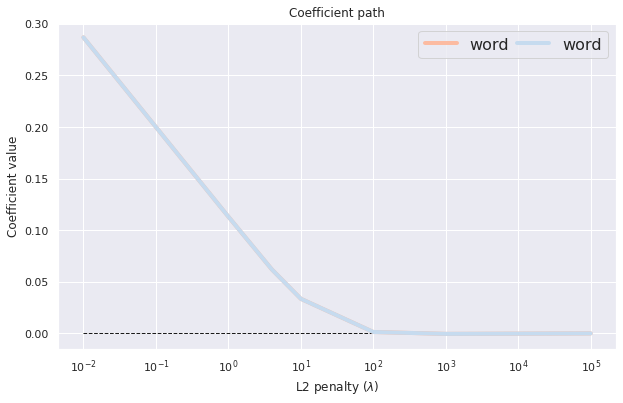

In [119]:
def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    def get_cmap_value(cmap, i, total_words):
        """
        Computes a nice scaling of from i=0 to i=total_words - 1
        for the given cmap
        """
        return cmap(0.8 * ((i + 1) / (total_words * 1.2) + 0.15))


    def plot_coeffs_for_words(ax, words, cmap):
        """
        Given an axes to plot on and a list of words and a cmap,
        plots the coefficient paths for each word in words
        """
        words_df = table[table['word'].isin(words)]
        words_df = words_df.reset_index(drop=True)  # To make indices sequential

        for i, row in words_df.iterrows():
            color = get_cmap_value(cmap, i, len(words))
            ax.plot(xx, row[row.index != 'word'], '-',
                    label=row['word'], linewidth=4.0, color=color)

    # Make a canvas to draw on
    fig, ax = plt.subplots(1, figsize=(10, 6))
   
    # Set up the xs to plot and draw a line for y=0
    xx = l2_penalty_list
    ax.plot(xx, [0.] * len(xx), '--', linewidth=1, color='k')

    # Plot the positive and negative coefficient paths
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    plot_coeffs_for_words(ax, positive_words, cmap_positive)
    plot_coeffs_for_words(ax, negative_words, cmap_negative)

    # Set up axis labels, scale, and legend  
    ax.legend(loc='best', ncol=2, prop={'size':16}, columnspacing=0.5 )
    ax.set_title('Coefficient path')
    ax.set_xlabel('L2 penalty ($\lambda$)')
    ax.set_ylabel('Coefficient value')
    ax.set_xscale('log')


make_coefficient_plot(coef_table, positive_words, negative_words, l2_penalty_list=l2_penalties)